# Data Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# Load the dataset
data_path = os.path.abspath(os.path.join(os.pardir, 'data/Physical_Activity_Monitoring_unlabeled.csv'))
raw = pd.read_csv(data_path)
print(f"There are {len(raw)} entries in this dataset")
raw.head()

There are 534601 entries in this dataset


,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.75,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.5447,27.3336,-5.76620,0.206416,0.348212,0.763201,-0.503652,5
1,3652.45,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.8257,-15.7719,-1.31395,0.578332,-0.566734,0.405888,-0.423791,2
2,504.76,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.8171,16.3089,25.29280,0.139776,0.676586,0.393796,0.606316,8
3,2801.61,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.7418,34.3566,21.32740,0.416303,0.783387,0.306464,0.345075,2
4,441.01,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.7798,-3.9981,10.99500,0.171133,-0.748343,0.252988,-0.588807,6


In [3]:
# Drop columns that are not useful
raw.drop(["subject_id"], axis=1, inplace=True)

# Drop additional highly correlated features identified in eda notebook 
raw.drop(["handAcc16_1", "handAcc16_2", "handAcc16_3", "chestAcc16_1", "chestAcc16_2", "chestAcc16_3", 
          "chestOrientation3", "ankleAcc16_1", "ankleAcc16_2"], axis=1, inplace=True)
raw.head(5)

,timestamp,handTemperature,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,...,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
0,252.75,34.8750,1.006100,7.44575,6.303650,-0.021952,0.004114,-0.000752,-9.99538,7.22910,...,0.043954,-0.025606,0.030239,-14.5447,27.3336,-5.76620,0.206416,0.348212,0.763201,-0.503652
1,3652.45,29.7500,-5.972500,3.22273,6.908970,0.116054,-0.375968,-0.012890,40.45580,-1.19692,...,-0.319186,-0.670163,1.786200,-32.8257,-15.7719,-1.31395,0.578332,-0.566734,0.405888,-0.423791
2,504.76,34.3750,-1.803500,-9.58937,1.073680,0.020131,0.042189,-0.011507,7.26741,24.43790,...,0.065654,-0.009741,-0.006579,-18.8171,16.3089,25.29280,0.139776,0.676586,0.393796,0.606316
3,2801.61,31.9375,-13.611500,5.91511,0.840377,1.715630,-0.050492,-1.829000,46.48220,-7.83916,...,2.970010,-0.163470,-3.495570,-26.7418,34.3566,21.32740,0.416303,0.783387,0.306464,0.345075
4,441.01,33.5000,0.144153,8.56816,4.822200,-0.006938,-0.007383,-0.032679,3.97764,-22.42320,...,0.013953,-0.028172,-0.003737,-17.7798,-3.9981,10.99500,0.171133,-0.748343,0.252988,-0.588807


### Imputation

In [4]:
# Create a copy of the raw data
raw_imputed = raw.copy()

# Fill the missing value with median due to skewness
for col in raw_imputed.columns:
    col_median = raw_imputed[col].median()
    raw_imputed[col].fillna(col_median, inplace=True)

# Check for successful imputation
raw_imputed.isna().sum().head()

timestamp          0
handTemperature    0
handAcc6_1         0
handAcc6_2         0
handAcc6_3         0
dtype: int64

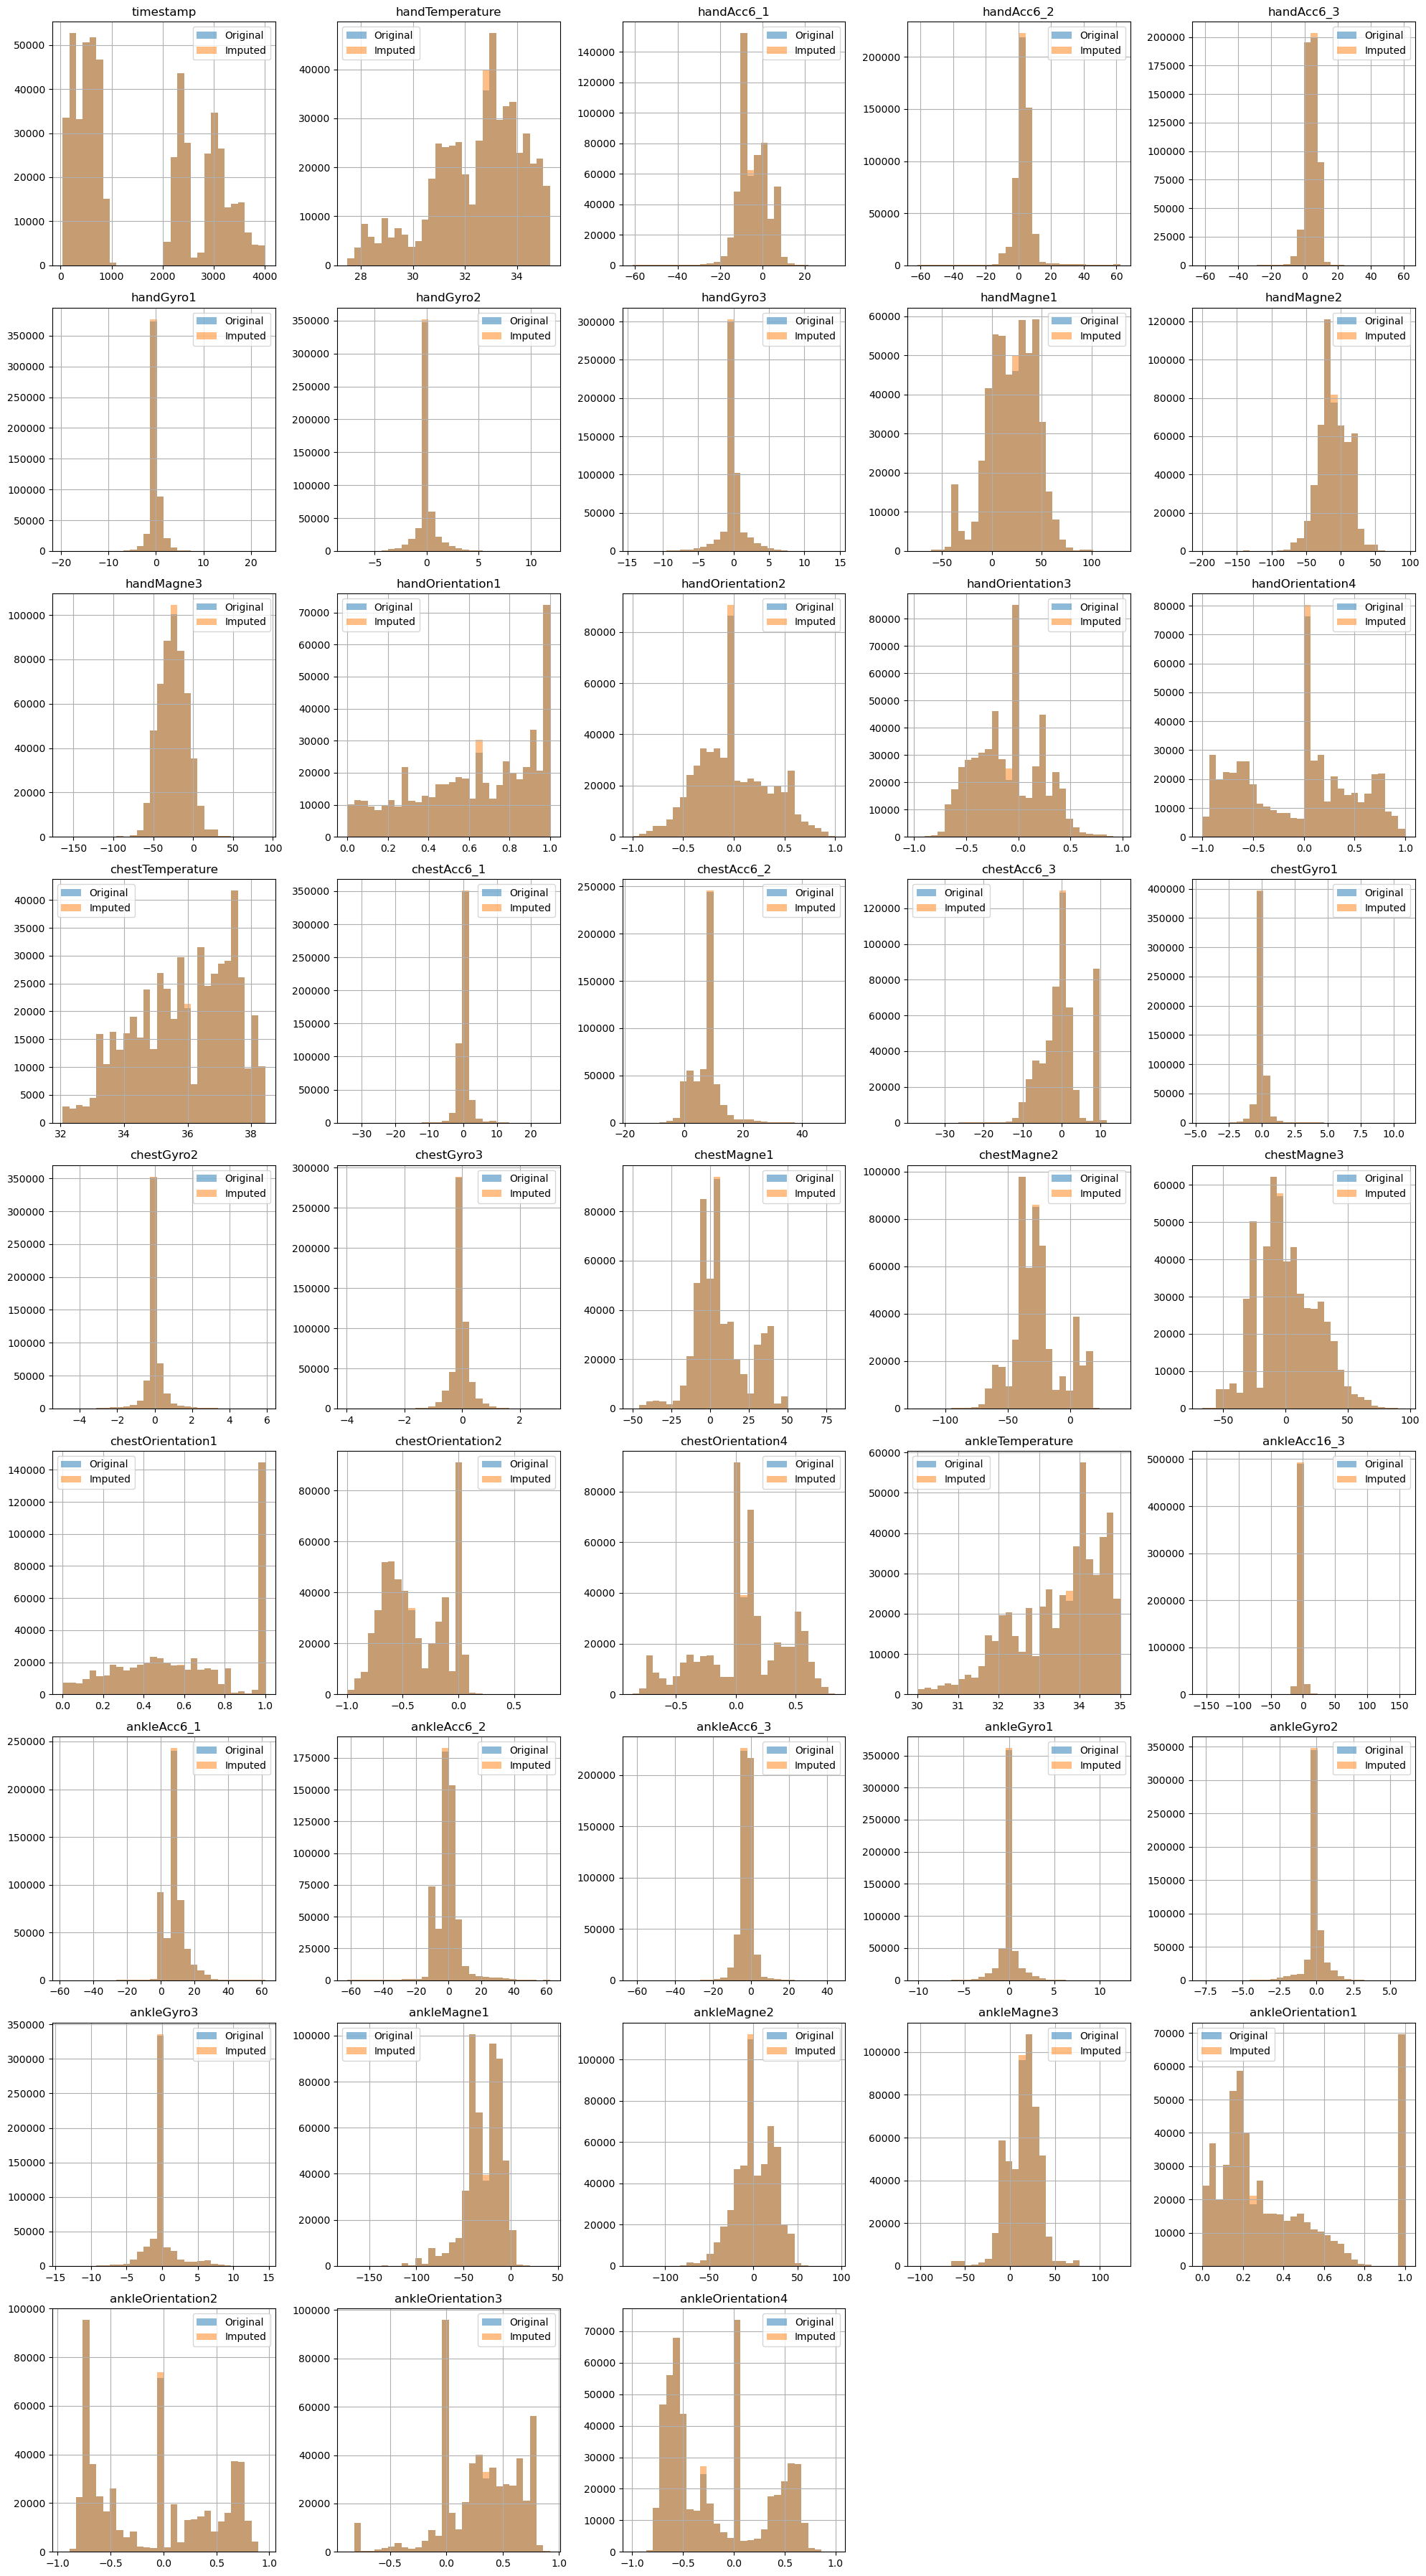

In [5]:
def plot_hist_comparison(df1, df2, df1_label='Original', df2_label='Imputed'):
    # Ensure both dataframes have the same columns
    assert df1.columns.equals(df2.columns), "DataFrames must have the same columns"
    
    # Plot histograms for each column
    data_columns = df1.columns

    # Determine the number of rows and columns for subplots
    n_cols = 5
    n_rows = int(np.ceil(len(data_columns) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

    for i, column in enumerate(data_columns):
        ax = axes[i // n_cols, i % n_cols]
        df1[column].hist(ax=ax, bins=30, alpha=0.5, label=df1_label)
        df2[column].hist(ax=ax, bins=30, alpha=0.5, label=df2_label)
        ax.set_title(column)
        ax.legend()

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    plt.tight_layout()
    plt.show()


# Compare df before and after imputation
plot_hist_comparison(raw, raw_imputed)

### Feature scaling

In [6]:
# Apply scaling for PCA
def scale_data(data, scaler = StandardScaler()):
    raw_scaled = pd.DataFrame(scaler.fit_transform(data))
    raw_scaled.columns = data.columns
    return raw_scaled

scaler = MinMaxScaler() # Can be adjusted as needed

raw_scaled = scale_data(raw_imputed, scaler)
raw_scaled.head(5)

# keep a copy of the timestamp column and add it back later after pca
timestamp = raw_scaled["timestamp"]

### Log Transformation

In [7]:
# Apply log transformation to handle outlier and skewness
raw_logged = np.log1p(raw_scaled)

### Column Subsets

In [8]:
print(raw_logged.columns)

Index(['timestamp', 'handTemperature', 'handAcc6_1', 'handAcc6_2',
       'handAcc6_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1',
       'handMagne2', 'handMagne3', 'handOrientation1', 'handOrientation2',
       'handOrientation3', 'handOrientation4', 'chestTemperature',
       'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 'chestGyro1', 'chestGyro2',
       'chestGyro3', 'chestMagne1', 'chestMagne2', 'chestMagne3',
       'chestOrientation1', 'chestOrientation2', 'chestOrientation4',
       'ankleTemperature', 'ankleAcc16_3', 'ankleAcc6_1', 'ankleAcc6_2',
       'ankleAcc6_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1',
       'ankleMagne2', 'ankleMagne3', 'ankleOrientation1', 'ankleOrientation2',
       'ankleOrientation3', 'ankleOrientation4'],
      dtype='object')


In [9]:
# Subset the data by category
hand_data = raw_logged.filter(regex='hand')
chest_data = raw_logged.filter(regex='chest')
ankle_data = raw_logged.filter(regex='ankle')

# Remove the timestamp column from the subsets (if it exists)
hand_data.drop(columns='timestamp', errors='ignore', inplace=True)
chest_data.drop(columns='timestamp', errors='ignore', inplace=True)
ankle_data.drop(columns='timestamp', errors='ignore', inplace=True)

# Keep a copy of the timestamp column
timestamp = raw_scaled["timestamp"]

/var/folders/9q/jp3hk0c504ldg7028p917bt00000gn/T/ipykernel_15044/3318793145.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand_data.drop(columns='timestamp', errors='ignore', inplace=True)
/var/folders/9q/jp3hk0c504ldg7028p917bt00000gn/T/ipykernel_15044/3318793145.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chest_data.drop(columns='timestamp', errors='ignore', inplace=True)
/var/folders/9q/jp3hk0c504ldg7028p917bt00000gn/T/ipykernel_15044/3318793145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [10]:
# Helper method to apply PCA
def apply_pca(subset, variance_threshold=0.8):
    pca = PCA(n_components=variance_threshold)
    principal_components = pca.fit_transform(subset)
    pca_columns = [f'{subset.columns[0].split("_")[0]}_PC{i+1}' for i in range(principal_components.shape[1])]
    return pd.DataFrame(principal_components, columns=pca_columns)

In [11]:
# Apply PCA for all columns
hand_pca = apply_pca(hand_data)
chest_pca = apply_pca(chest_data)
ankle_pca = apply_pca(ankle_data)

In [12]:
# Combine the principal components with the timestamp column
combined_data = pd.concat([timestamp, hand_pca, chest_pca, ankle_pca], axis=1)
combined_data.head()

,timestamp,handTemperature_PC1,handTemperature_PC2,handTemperature_PC3,handTemperature_PC4,chestTemperature_PC1,chestTemperature_PC2,chestTemperature_PC3,chestTemperature_PC4,ankleTemperature_PC1,ankleTemperature_PC2,ankleTemperature_PC3,ankleTemperature_PC4
0,0.054178,-0.213816,0.200349,-0.203978,0.096712,0.320275,-0.153086,-0.041440,0.066807,-0.024567,-0.172732,0.079060,-0.181053
1,0.910510,-0.241962,-0.031598,0.230551,-0.047426,-0.323038,0.207079,0.076691,-0.148040,0.093874,0.230460,-0.005042,-0.086713
2,0.117655,0.144560,-0.078564,-0.168816,0.187043,0.000326,-0.173016,-0.075871,-0.121592,-0.266545,-0.295669,-0.070558,0.009792
3,0.696197,0.131698,-0.165911,0.054803,-0.046357,-0.194586,-0.069493,0.099773,-0.088344,-0.335737,-0.113271,-0.112913,-0.049474
4,0.101598,-0.247920,0.076421,-0.112464,0.041920,0.051401,-0.027447,-0.022827,-0.128282,0.321787,-0.007032,-0.106187,-0.066697


In [20]:
# Save to pickle
combined_data.to_pickle('../data/pca_with_subsets.pkl')
print("done")

done


### Dimensionality Reduction

In [ ]:
# Perform PCA
pca = PCA(n_components=35)  # Adjust as needed
principal_components = pca.fit_transform(raw_logged)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

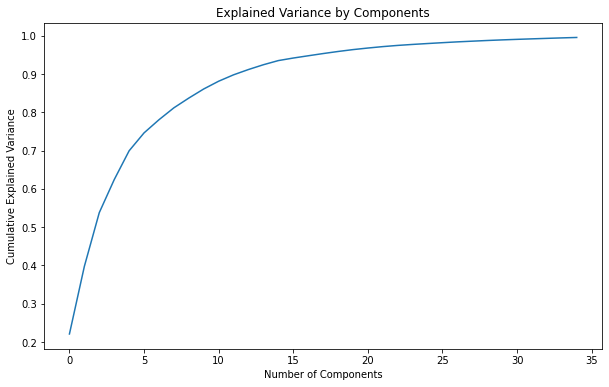

In [ ]:
# Explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

In [ ]:
# Find a specific number of components that explain at least 95% of the variance
pca = PCA(n_components=0.8) # Adjust if needed
principal_components = pca.fit_transform(raw_logged)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

In [ ]:
# Number of components selected
n_components = pca.n_components_
print(f'Number of components selected: {n_components}')

# Check principal components
pca_df.head()

Number of components selected: 8


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.486093,-0.158049,-0.186432,-0.008248,0.336819,0.013108,-0.034847,-0.113593
1,0.262609,0.378496,0.429960,0.149426,0.054246,-0.078464,-0.104022,0.011744
2,0.008030,-0.234484,-0.428483,-0.115379,0.139530,-0.090999,-0.013137,0.022662
3,0.396516,0.107089,-0.262947,-0.081122,0.031191,-0.115548,-0.166672,0.049578
4,-0.321760,-0.168364,0.277331,-0.054088,0.117170,0.061274,-0.053198,0.112418


In [ ]:
# Add scaled timestamp back to the dimension-reduced dataset
pca_df["timestamp"] = timestamp

In [ ]:
# Explained variance ratio of each component
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained variance ratio of each component: {explained_variance_ratio}')

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print(f'Cumulative explained variance: {cumulative_explained_variance}')

Explained variance ratio of each component: [0.22087294 0.17656817 0.14039456 0.08611092 0.07544572 0.0467673
 0.03435876 0.03116218]
Cumulative explained variance: [0.22087294 0.39744111 0.53783567 0.62394659 0.69939232 0.74615961
 0.78051837 0.81168055]


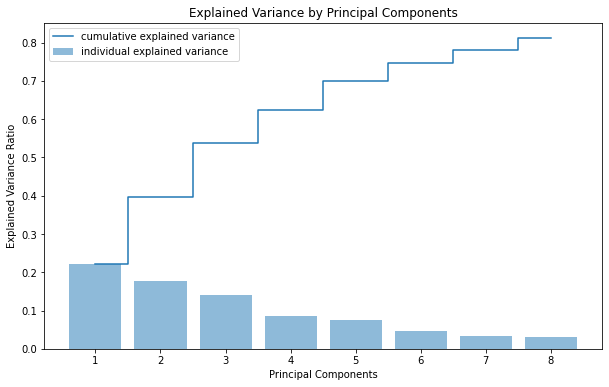

In [ ]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()

In [ ]:
# Data integrity check: no NaNs or infinite values
assert not np.any(np.isnan(principal_components))
assert not np.any(np.isinf(principal_components))

### Save DataFrame

In [ ]:
pca_df.to_pickle('../data/pca_df.pkl')
print("done")

done
